In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import Embedding, LSTM, Linear
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from random import shuffle

import re
import pymorphy2
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import Phrases

import time
import json
from tqdm import tqdm

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Обработка данных

In [3]:
train = pd.read_csv('datasets/train.csv', index_col=0)
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45398 entries, 12405 to 13043
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   45398 non-null  object
 1   text    45398 non-null  object
 2   from    45398 non-null  object
 3   lemma   45398 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [4]:
test = pd.read_csv('datasets/test.csv', index_col=0)
test = test.dropna()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5960 entries, 14745 to 20671
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5960 non-null   object
 1   text    5960 non-null   object
 2   from    5960 non-null   object
 3   lemma   5960 non-null   object
dtypes: object(4)
memory usage: 232.8+ KB


In [5]:
score_enc = OneHotEncoder(handle_unknown='ignore')
X = test.label.to_numpy().reshape(-1, 1)

unique_items = np.unique(X).reshape(-1, 1)
score_enc.fit(unique_items)

print('Категории:', score_enc.categories_, sep='\n')
print()
for i, desc in zip(score_enc.categories_[0], ['Отрицательные\t', 'Положительные\t']):
    print(desc, i, score_enc.transform(np.array([i]).reshape(-1, 1)).toarray())

Категории:
[array(['negative', 'positive'], dtype=object)]

Отрицательные	 negative [[1. 0.]]
Положительные	 positive [[0. 1.]]


In [6]:
def convert_label(df):
    return score_enc.transform(df.to_numpy().reshape(-1, 1))

X_train = train.lemma.tolist()
y_train = convert_label(train.label)
len(X_train), y_train

In [8]:
X_test = test.lemma.tolist()
y_test = convert_label(test.label)
len(X_test), y_test

(5960,
 <5960x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 5960 stored elements in Compressed Sparse Row format>)

## Преобразование преложений в набор токенов равной длины

In [9]:
stop_list = []

with open('datasets/stop_list.txt', 'r') as f:
    stop_list = json.loads(f.read())

stop_list[:10]

['и', 'в', 'во', 'что', 'он', 'на', 'я', 'с', 'со', 'как']

In [11]:
padding = '__pad__'

In [12]:
all_words = ' '.join(X_train)
unique_words = set(all_words.split(' ') + [padding]) - set(stop_list)
word_dict = {value: key for key, value in enumerate(unique_words)}
len(word_dict), word_dict[padding]

(63899, 50606)

In [13]:
word_dict

{'прослоупочить': 0,
 'наличку': 1,
 'урокахва': 2,
 'центр': 3,
 'островок': 4,
 'временный': 5,
 'радость': 6,
 'отчитываться': 7,
 'проплата': 8,
 'ломота': 9,
 'невезучий': 10,
 'обиднее': 11,
 'фуршетный': 12,
 'раздевая': 13,
 'вытеснить': 14,
 'амралтын': 15,
 'удастсян': 16,
 'бардель': 17,
 'диабетик': 18,
 'бауманок': 19,
 'тюрьма': 20,
 'ощущаешь': 21,
 'зокончивый': 22,
 'разгребая': 23,
 'купоник': 24,
 'проитивный': 25,
 'двоеточие': 26,
 'арбузик': 27,
 'глюкометр': 28,
 'здравствуйст': 29,
 'юличка': 30,
 'эйнштейн': 31,
 'информационно': 32,
 'загс': 33,
 'прошвырнуться': 34,
 'заур': 35,
 'впечетлить': 36,
 'молочка': 37,
 'вьрос': 38,
 'популяризация': 39,
 'ульяна': 40,
 'длительно': 41,
 'осователь': 42,
 'неоценимый': 43,
 'ахаахха': 44,
 'черно': 45,
 'ручник': 46,
 'распеть': 47,
 'лицензия': 48,
 'веденеева': 49,
 'веремить': 50,
 'поплавок': 51,
 'вечерденьутро': 52,
 'воспитательный': 53,
 'соотвествеено': 54,
 'увы': 55,
 'полчище': 56,
 'полочка': 57,
 'пры

In [14]:
def text2numbers(text, dict_): 
    text = text.split(' ')
    sequence = []

    for i in text:
        if i in dict_.keys():
            sequence.append(dict_[i])

    return sequence

In [15]:
def texts2tokens(row):
    return [text2numbers(i, dict_=word_dict) for i in row]

In [16]:
def set_text_len(texts, max_len):
    array = np.zeros([len(texts), max_len])

    i = 0
    for value in texts:
        tmp = max_len-len(value)
        tmp = tmp if tmp > 0 else 0

        text = np.concatenate((value[:max_len], np.zeros(tmp)))
        array[i] = text
        i+=1

    return array 

In [17]:
X_train = texts2tokens(X_train)
X_test = texts2tokens(X_test)

In [18]:
max_len = 230
X_train = set_text_len(X_train, max_len)
X_test = set_text_len(X_test, max_len)

X_train.shape, X_test.shape

((45398, 230), (5960, 230))

In [19]:
train_pre = [np.argmax(i) for i in y_train]

unique, counts = np.unique(train_pre, return_counts=True)
print(unique, counts)
counts = [i/len(train_pre) for i in counts]
class_weights = np.array(counts)
print(class_weights)

[0 1] [14601 30797]
[0.3216221 0.6783779]


# Создание модели

In [24]:
def get_dataloaders(train_texts, test_texts, batch_size = 10): # nvidia-smi
    train = TensorDataset(torch.IntTensor(train_texts), torch.FloatTensor(y_train.toarray()))
    test = TensorDataset(torch.IntTensor(test_texts), torch.FloatTensor(y_test.toarray()))
    
    train_loader = DataLoader(train,  batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [34]:
train_loader, test_loader = get_dataloaders(X_train, X_test, batch_size=100)

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, padding_idx):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = Embedding(input_size, embedding_dim, padding_idx = padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=2, batch_first=True, dropout=0.25)
        self.fc = Linear(hidden_size, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)

        output = self.fc(output[:, -1, :])
        output = self.sig(output) #.reshape(-1, 1, self.output_size) ### !!!!!!!!!!!
       
        return output

In [35]:
model = LSTM(input_size=len(word_dict),
            embedding_dim=256,
            hidden_size=512,
            output_size=2,
            padding_idx=word_dict[padding]
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
weight = torch.Tensor(class_weights).to(device)
print('Weight', weight)
loss_fn = nn.BCELoss(weight=weight)

print(model)

Weight tensor([0.3216, 0.6784], device='cuda:0')
LSTM(
  (embedding): Embedding(63899, 256, padding_idx=50606)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [28]:
metrics_dict_train = {}
metrics_dict_test = {}

In [30]:
def metrics_(model, data_loader, device, epoch, is_train=False):
    correct = 0

    pred = []
    target = []
    total_loss = 0
    
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            total_loss += loss_fn(outputs, y)

            pred.extend(outputs.cpu())
            target.extend(y.cpu())


        pred_bin = [i.argmax() for i in pred]
        label_bin = [i.argmax() for i in target]
        
        f1_score = metrics.f1_score(pred_bin, label_bin, average='weighted')
        precision = metrics.precision_score(pred_bin, label_bin, average='weighted')
        recall = metrics.recall_score(pred_bin, label_bin, average='weighted')
        accuracy = metrics.accuracy_score(pred_bin, label_bin)

        tmp_metrics = {'f1-score': f1_score, 'precision': precision, 'recall': recall, 'accuracy': accuracy}
        if is_train:
            metrics_dict_train[epoch] = tmp_metrics
        else:
            metrics_dict_test[epoch] = tmp_metrics

        print('F1-мера:',str('{:04.2f}'.format(f1_score*100))+'%')
        print('Precision:',str('{:04.2f}'.format(precision*100))+'%')
        print('Recall:',str('{:04.2f}'.format(recall*100))+'%')
        print('Accuracy:',str('{:04.2f}'.format(accuracy*100))+'%')
        print('Loss:',str('{:04.2f}'.format(total_loss)))

        print('Матрица ошибок:')
        print(pd.DataFrame(confusion_matrix(label_bin, pred_bin)))
        print('------------------------------------------------')
        print('Отчет о классификации:')
        print(classification_report(label_bin, pred_bin))

In [31]:
def train_model(model, epochs = 10, prefix='e'):
    start = time.time()
    global metrics_dict_train, metrics_dict_test
    metrics_dict_train = {}
    metrics_dict_test = {}
    
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            text, labels = data
            text = text.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(text)
            # print(outputs.shape, labels.shape)
            loss = loss_fn(outputs, labels) # .reshape(-1, 2)
            loss.backward()
            optimizer.step()

        # torch.save(model, f'models/{prefix}{epoch}_lstm.pt')
    
        with torch.set_grad_enabled(False):
            print(f'Epoch: {epoch}')
            print('Train')
            metrics_(model, train_loader, device, epoch, is_train=True)
            print('Test')
            metrics_(model, test_loader, device, epoch)

        
    print(f'Total time: {(time.time() - start)/60:.2f} min')

In [32]:
def draw_metrics():
    fig, ax = plt.subplots(2, 2)
    fig.suptitle('Метрики')
    fig.set_size_inches(15, 7)
    
    amount = len(metrics_dict_train)
    
    for i, name in enumerate(['accuracy', 'precision', 'recall', 'f1-score']):
        train_metrics = [metrics_dict_train[i][name] for i in range(amount)]
        test_metrics = [metrics_dict_test[i][name] for i in range(amount)]
    
        x = list(range(amount))
        current_ax = ax[i%2][i//2]
        current_ax.plot(x, train_metrics, label='Train')
        current_ax.plot(x, test_metrics, label='Test')
        current_ax.set_title(name)
        current_ax.legend(loc='upper left')
        current_ax.grid()

In [36]:
train_model(model, epochs = 10)

100%|█████████████████████████████████████████| 454/454 [01:47<00:00,  4.22it/s]


Epoch: 0
Train


/home/den/Documents/UNIC/venv3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1-мера: 80.84%
Precision: 100.00%
Recall: 67.84%
Accuracy: 67.84%
Loss: 142.42
Матрица ошибок:
   0      1
0  0  14601
1  0  30797
------------------------------------------------
Отчет о классификации:


/home/den/Documents/UNIC/venv3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/den/Documents/UNIC/venv3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/den/Documents/UNIC/venv3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14601
           1       0.68      1.00      0.81     30797

    accuracy                           0.68     45398
   macro avg       0.34      0.50      0.40     45398
weighted avg       0.46      0.68      0.55     45398

Test


/home/den/Documents/UNIC/venv3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/den/Documents/UNIC/venv3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/den/Documents/UNIC/venv3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

F1-мера: 66.68%
Precision: 100.00%
Recall: 50.02%
Accuracy: 50.02%
Loss: 22.80
Матрица ошибок:
   0     1
0  0  2979
1  0  2981
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2979
           1       0.50      1.00      0.67      2981

    accuracy                           0.50      5960
   macro avg       0.25      0.50      0.33      5960
weighted avg       0.25      0.50      0.33      5960



100%|█████████████████████████████████████████| 454/454 [01:46<00:00,  4.27it/s]


Epoch: 1
Train
F1-мера: 86.21%
Precision: 86.38%
Recall: 86.10%
Accuracy: 86.10%
Loss: 70.98
Матрица ошибок:
       0      1
0  11042   3559
1   2751  28046
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     14601
           1       0.89      0.91      0.90     30797

    accuracy                           0.86     45398
   macro avg       0.84      0.83      0.84     45398
weighted avg       0.86      0.86      0.86     45398

Test
F1-мера: 74.93%
Precision: 76.61%
Recall: 74.68%
Accuracy: 74.68%
Loss: 16.12
Матрица ошибок:
      0     1
0  1932  1047
1   462  2519
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      2979
           1       0.71      0.85      0.77      2981

    accuracy                           0.75      5960
   macro avg 

100%|█████████████████████████████████████████| 454/454 [01:46<00:00,  4.27it/s]


Epoch: 2
Train
F1-мера: 91.48%
Precision: 91.47%
Recall: 91.50%
Accuracy: 91.50%
Loss: 49.22
Матрица ошибок:
       0      1
0  12830   1771
1   2086  28711
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     14601
           1       0.94      0.93      0.94     30797

    accuracy                           0.92     45398
   macro avg       0.90      0.91      0.90     45398
weighted avg       0.92      0.92      0.92     45398

Test
F1-мера: 77.50%
Precision: 78.02%
Recall: 77.43%
Accuracy: 77.43%
Loss: 14.53
Матрица ошибок:
      0     1
0  2145   834
1   511  2470
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      2979
           1       0.75      0.83      0.79      2981

    accuracy                           0.77      5960
   macro avg 

100%|█████████████████████████████████████████| 454/454 [01:46<00:00,  4.28it/s]


Epoch: 3
Train
F1-мера: 94.94%
Precision: 94.95%
Recall: 94.96%
Accuracy: 94.96%
Loss: 32.55
Матрица ошибок:
       0      1
0  13714    887
1   1400  29397
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     14601
           1       0.97      0.95      0.96     30797

    accuracy                           0.95     45398
   macro avg       0.94      0.95      0.94     45398
weighted avg       0.95      0.95      0.95     45398

Test
F1-мера: 77.67%
Precision: 77.93%
Recall: 77.63%
Accuracy: 77.63%
Loss: 15.40
Матрица ошибок:
      0     1
0  2198   781
1   552  2429
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      2979
           1       0.76      0.81      0.78      2981

    accuracy                           0.78      5960
   macro avg 

100%|█████████████████████████████████████████| 454/454 [01:46<00:00,  4.28it/s]


Epoch: 4
Train
F1-мера: 97.14%
Precision: 97.14%
Recall: 97.14%
Accuracy: 97.14%
Loss: 20.47
Матрица ошибок:
       0      1
0  14015    586
1    712  30085
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     14601
           1       0.98      0.98      0.98     30797

    accuracy                           0.97     45398
   macro avg       0.97      0.97      0.97     45398
weighted avg       0.97      0.97      0.97     45398

Test
F1-мера: 77.27%
Precision: 77.74%
Recall: 77.21%
Accuracy: 77.21%
Loss: 18.97
Матрица ошибок:
      0     1
0  2148   831
1   527  2454
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      2979
           1       0.75      0.82      0.78      2981

    accuracy                           0.77      5960
   macro avg 

100%|█████████████████████████████████████████| 454/454 [01:45<00:00,  4.29it/s]


Epoch: 5
Train
F1-мера: 98.21%
Precision: 98.21%
Recall: 98.20%
Accuracy: 98.20%
Loss: 14.14
Матрица ошибок:
       0      1
0  14113    488
1    327  30470
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     14601
           1       0.98      0.99      0.99     30797

    accuracy                           0.98     45398
   macro avg       0.98      0.98      0.98     45398
weighted avg       0.98      0.98      0.98     45398

Test
F1-мера: 76.50%
Precision: 77.54%
Recall: 76.36%
Accuracy: 76.36%
Loss: 21.25
Матрица ошибок:
      0     1
0  2046   933
1   476  2505
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      2979
           1       0.73      0.84      0.78      2981

    accuracy                           0.76      5960
   macro avg 

100%|█████████████████████████████████████████| 454/454 [01:45<00:00,  4.29it/s]


Epoch: 6
Train
F1-мера: 98.70%
Precision: 98.71%
Recall: 98.70%
Accuracy: 98.70%
Loss: 10.55
Матрица ошибок:
       0      1
0  14194    407
1    184  30613
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     14601
           1       0.99      0.99      0.99     30797

    accuracy                           0.99     45398
   macro avg       0.99      0.98      0.99     45398
weighted avg       0.99      0.99      0.99     45398

Test
F1-мера: 76.48%
Precision: 77.65%
Recall: 76.33%
Accuracy: 76.33%
Loss: 22.87
Матрица ошибок:
      0     1
0  2031   948
1   463  2518
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      2979
           1       0.73      0.84      0.78      2981

    accuracy                           0.76      5960
   macro avg 

100%|█████████████████████████████████████████| 454/454 [01:45<00:00,  4.29it/s]


Epoch: 7
Train
F1-мера: 98.96%
Precision: 98.96%
Recall: 98.96%
Accuracy: 98.96%
Loss: 8.14
Матрица ошибок:
       0      1
0  14276    325
1    148  30649
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     14601
           1       0.99      1.00      0.99     30797

    accuracy                           0.99     45398
   macro avg       0.99      0.99      0.99     45398
weighted avg       0.99      0.99      0.99     45398

Test
F1-мера: 76.52%
Precision: 77.44%
Recall: 76.39%
Accuracy: 76.39%
Loss: 29.08
Матрица ошибок:
      0     1
0  2060   919
1   488  2493
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75      2979
           1       0.73      0.84      0.78      2981

    accuracy                           0.76      5960
   macro avg  

100%|█████████████████████████████████████████| 454/454 [01:46<00:00,  4.28it/s]


Epoch: 8
Train
F1-мера: 99.17%
Precision: 99.17%
Recall: 99.17%
Accuracy: 99.17%
Loss: 6.76
Матрица ошибок:
       0      1
0  14352    249
1    129  30668
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     14601
           1       0.99      1.00      0.99     30797

    accuracy                           0.99     45398
   macro avg       0.99      0.99      0.99     45398
weighted avg       0.99      0.99      0.99     45398

Test
F1-мера: 76.83%
Precision: 77.47%
Recall: 76.74%
Accuracy: 76.74%
Loss: 29.86
Матрица ошибок:
      0     1
0  2107   872
1   514  2467
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      2979
           1       0.74      0.83      0.78      2981

    accuracy                           0.77      5960
   macro avg  

100%|█████████████████████████████████████████| 454/454 [01:48<00:00,  4.19it/s]


Epoch: 9
Train
F1-мера: 99.03%
Precision: 99.03%
Recall: 99.03%
Accuracy: 99.03%
Loss: 8.35
Матрица ошибок:
       0      1
0  14356    245
1    195  30602
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     14601
           1       0.99      0.99      0.99     30797

    accuracy                           0.99     45398
   macro avg       0.99      0.99      0.99     45398
weighted avg       0.99      0.99      0.99     45398

Test
F1-мера: 76.66%
Precision: 77.15%
Recall: 76.59%
Accuracy: 76.59%
Loss: 24.99
Матрица ошибок:
      0     1
0  2125   854
1   541  2440
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      2979
           1       0.74      0.82      0.78      2981

    accuracy                           0.77      5960
   macro avg  

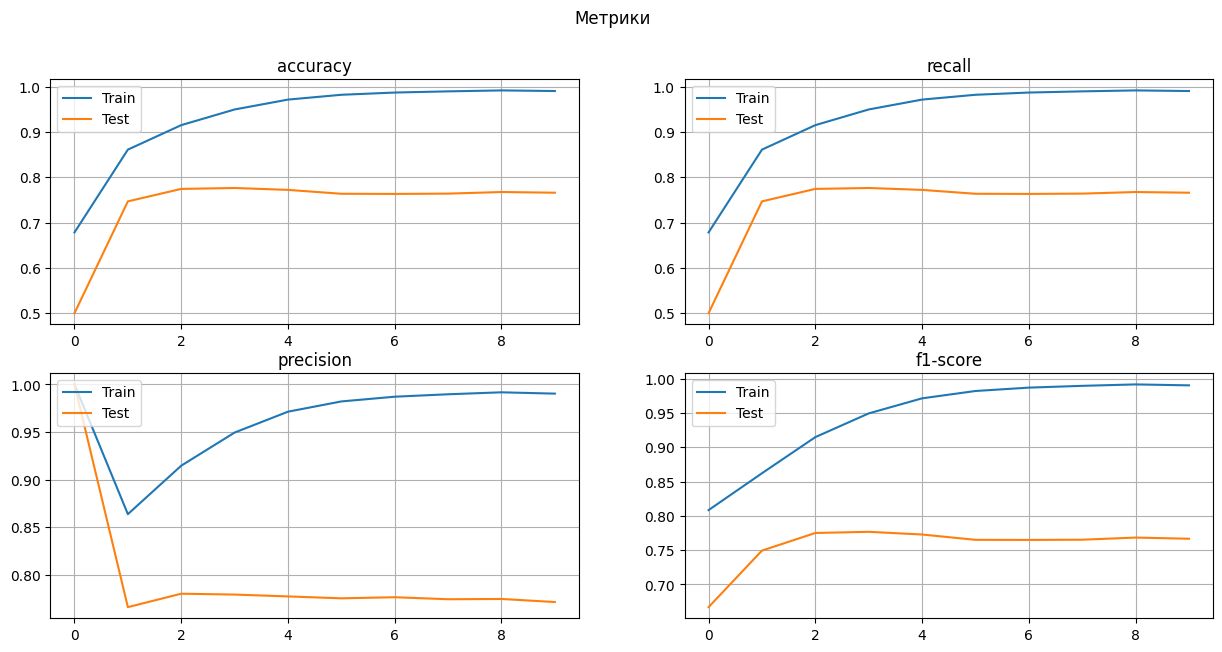

In [37]:
draw_metrics()

## №2 word2vec

In [82]:
embedding_dim = 64

In [83]:
corp = del_stopwords(train.lemma.tolist())

In [84]:
corp.append(['__pad__'])
w2v_model = Word2Vec(corp, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [85]:
def preprocess_text(texts, word_dict, max_len, pad_index):
    result = []
    for i in texts:
        tmp = []
        i.append('__pad__') # for bigrams
        for j in range(max_len):
            if len(i)-1 > j and f'{i[j]}_{i[j+1]}' in word_dict:# for bigrams
                word = f'{i[j]}_{i[j+1]}'
                tmp.append(word_dict[word])
            elif len(i)-1 > j and i[j] in word_dict:
                word = i[j]
                tmp.append(word_dict[word])
            else:
                tmp.append(pad_index)
        result.append(tmp)
    return result

pad_idx = w2v_model.wv.get_index('__pad__')
tmp = np.array(preprocess_text(corp[:5], w2v_model.wv.key_to_index, 6, w2v_model.wv.get_index('__pad__')))
tmp.shape, tmp

((5, 6),
 array([[  852, 38242, 38242, 38242, 38242, 38242],
        [    0,    53,   227,   402,  1042,   114],
        [  799, 38242, 38242, 38242, 38242, 38242],
        [10218,  2485,     0,  5029, 38242, 38242],
        [17796,   217,   778,   624, 38242, 38242]]))

In [86]:
train_corp = del_stopwords(train.lemma.tolist())
test_corp = del_stopwords(test.lemma.tolist())

In [87]:
train_texts = preprocess_text(train_corp, w2v_model.wv.key_to_index, max_len, pad_idx)
test_texts = preprocess_text(test_corp, w2v_model.wv.key_to_index, max_len, pad_idx)

In [88]:
num = len(w2v_model.wv.index_to_key)
dim = w2v_model.vector_size
num, dim

(63899, 64)

In [89]:
def get_embedding(model, num, dim):
    emb_weights = np.zeros((num, dim))
    
    for key, i in enumerate(model.wv.key_to_index.keys()):
        emb_weights[key] = model.wv[i]
    emb_weights = torch.Tensor(emb_weights)
    print('Embedding len:', emb_weights.shape)
    return emb_weights

In [90]:
emb_weights = get_embedding(w2v_model, num, dim)

Embedding len: torch.Size([63899, 64])


In [91]:
train_loader, test_loader = get_dataloaders(train_texts, test_texts, batch_size=200)

In [92]:
class LSTM(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, pad_idx, weigths):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = Embedding(input_size, embedding_dim,  _weight = weigths, padding_idx = pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=2, batch_first=True, dropout=0.25)
        self.fc = Linear(hidden_size, output_size)
        # self.drop = nn.Dropout(0.1)
        self.sig = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        # print(embedded.shape)
        output, (hidden, cell) = self.lstm(embedded)
        # print(output.shape)
        # output = self.drop(output)
        output = self.fc(output[:, -1, :])
        output = self.sig(output)
       
        return output

In [93]:
lstm = LSTM(input_size=num,
            embedding_dim=embedding_dim,
            hidden_size=128,
            output_size=2,
            pad_idx = word_dict['__pad__'],
            weigths = emb_weights
)

lstm = lstm.to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
weight = torch.Tensor(class_weights).to(device)
print('Weight', weight)
loss_fn = nn.BCELoss(weight=weight)

print(lstm)

Weight tensor([0.3216, 0.6784], device='cuda:0')
LSTM(
  (embedding): Embedding(63899, 64, padding_idx=50606)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [94]:
train_model(lstm, epochs = 10)

100%|█████████████████████████████████████████| 227/227 [00:17<00:00, 12.71it/s]


Epoch: 0
Train
F1-мера: 80.45%
Precision: 99.15%
Recall: 68.10%
Accuracy: 68.10%
Loss: 71.41
Матрица ошибок:
     0      1
0  197  14404
1   79  30718
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.71      0.01      0.03     14601
           1       0.68      1.00      0.81     30797

    accuracy                           0.68     45398
   macro avg       0.70      0.51      0.42     45398
weighted avg       0.69      0.68      0.56     45398

Test
F1-мера: 66.38%
Precision: 99.12%
Recall: 50.37%
Accuracy: 50.37%
Loss: 10.89
Матрица ошибок:
    0     1
0  29  2950
1   8  2973
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.78      0.01      0.02      2979
           1       0.50      1.00      0.67      2981

    accuracy                           0.50      5960
   macro avg       0.64  

100%|█████████████████████████████████████████| 227/227 [00:17<00:00, 12.81it/s]


Epoch: 1
Train
F1-мера: 77.17%
Precision: 80.59%
Recall: 75.55%
Accuracy: 75.55%
Loss: 62.55
Матрица ошибок:
      0      1
0  6533   8068
1  3032  27765
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.68      0.45      0.54     14601
           1       0.77      0.90      0.83     30797

    accuracy                           0.76     45398
   macro avg       0.73      0.67      0.69     45398
weighted avg       0.75      0.76      0.74     45398

Test
F1-мера: 65.49%
Precision: 72.74%
Recall: 63.79%
Accuracy: 63.79%
Loss: 10.72
Матрица ошибок:
      0     1
0  1270  1709
1   449  2532
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.74      0.43      0.54      2979
           1       0.60      0.85      0.70      2981

    accuracy                           0.64      5960
   macro avg    

100%|█████████████████████████████████████████| 227/227 [00:18<00:00, 12.55it/s]


Epoch: 2
Train
F1-мера: 80.49%
Precision: 99.10%
Recall: 68.39%
Accuracy: 68.39%
Loss: 70.03
Матрица ошибок:
     0      1
0  297  14304
1   48  30749
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.86      0.02      0.04     14601
           1       0.68      1.00      0.81     30797

    accuracy                           0.68     45398
   macro avg       0.77      0.51      0.43     45398
weighted avg       0.74      0.68      0.56     45398

Test
F1-мера: 66.45%
Precision: 99.03%
Recall: 50.81%
Accuracy: 50.81%
Loss: 11.53
Матрица ошибок:
    0     1
0  50  2929
1   3  2978
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.94      0.02      0.03      2979
           1       0.50      1.00      0.67      2981

    accuracy                           0.51      5960
   macro avg       0.72  

100%|█████████████████████████████████████████| 227/227 [00:18<00:00, 12.40it/s]


Epoch: 3
Train
F1-мера: 76.88%
Precision: 76.95%
Recall: 76.82%
Accuracy: 76.82%
Loss: 53.28
Матрица ошибок:
      0      1
0  9205   5396
1  5125  25672
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.64      0.63      0.64     14601
           1       0.83      0.83      0.83     30797

    accuracy                           0.77     45398
   macro avg       0.73      0.73      0.73     45398
weighted avg       0.77      0.77      0.77     45398

Test
F1-мера: 68.83%
Precision: 69.50%
Recall: 68.71%
Accuracy: 68.71%
Loss: 9.31
Матрица ошибок:
      0     1
0  1859  1120
1   745  2236
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67      2979
           1       0.67      0.75      0.71      2981

    accuracy                           0.69      5960
   macro avg     

100%|█████████████████████████████████████████| 227/227 [00:17<00:00, 12.69it/s]


Epoch: 4
Train
F1-мера: 65.66%
Precision: 79.92%
Recall: 66.12%
Accuracy: 66.12%
Loss: 57.50
Матрица ошибок:
       0      1
0  14019    582
1  14798  15999
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.49      0.96      0.65     14601
           1       0.96      0.52      0.68     30797

    accuracy                           0.66     45398
   macro avg       0.73      0.74      0.66     45398
weighted avg       0.81      0.66      0.67     45398

Test
F1-мера: 68.85%
Precision: 83.47%
Recall: 65.42%
Accuracy: 65.42%
Loss: 9.11
Матрица ошибок:
      0     1
0  2844   135
1  1926  1055
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.60      0.95      0.73      2979
           1       0.89      0.35      0.51      2981

    accuracy                           0.65      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:18<00:00, 12.58it/s]


Epoch: 5
Train
F1-мера: 75.96%
Precision: 77.50%
Recall: 76.65%
Accuracy: 76.65%
Loss: 50.37
Матрица ошибок:
       0      1
0  11924   2677
1   7924  22873
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.60      0.82      0.69     14601
           1       0.90      0.74      0.81     30797

    accuracy                           0.77     45398
   macro avg       0.75      0.78      0.75     45398
weighted avg       0.80      0.77      0.77     45398

Test
F1-мера: 72.06%
Precision: 73.54%
Recall: 71.81%
Accuracy: 71.81%
Loss: 8.66
Матрица ошибок:
      0     1
0  2416   563
1  1117  1864
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      2979
           1       0.77      0.63      0.69      2981

    accuracy                           0.72      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:18<00:00, 12.50it/s]


Epoch: 6
Train
F1-мера: 74.07%
Precision: 77.58%
Recall: 74.89%
Accuracy: 74.89%
Loss: 50.80
Матрица ошибок:
       0      1
0  12578   2023
1   9376  21421
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.57      0.86      0.69     14601
           1       0.91      0.70      0.79     30797

    accuracy                           0.75     45398
   macro avg       0.74      0.78      0.74     45398
weighted avg       0.80      0.75      0.76     45398

Test
F1-мера: 72.58%
Precision: 75.61%
Recall: 72.08%
Accuracy: 72.08%
Loss: 8.67
Матрица ошибок:
      0     1
0  2543   436
1  1228  1753
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2979
           1       0.80      0.59      0.68      2981

    accuracy                           0.72      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:17<00:00, 12.67it/s]


Epoch: 7
Train
F1-мера: 78.79%
Precision: 78.70%
Recall: 78.91%
Accuracy: 78.91%
Loss: 48.37
Матрица ошибок:
       0      1
0  10144   4457
1   5119  25678
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68     14601
           1       0.85      0.83      0.84     30797

    accuracy                           0.79     45398
   macro avg       0.76      0.76      0.76     45398
weighted avg       0.79      0.79      0.79     45398

Test
F1-мера: 71.34%
Precision: 71.54%
Recall: 71.31%
Accuracy: 71.31%
Loss: 8.60
Матрица ошибок:
      0     1
0  2023   956
1   754  2227
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70      2979
           1       0.70      0.75      0.72      2981

    accuracy                           0.71      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:18<00:00, 12.59it/s]


Epoch: 8
Train
F1-мера: 78.71%
Precision: 78.82%
Recall: 79.08%
Accuracy: 79.08%
Loss: 47.18
Матрица ошибок:
       0      1
0  11052   3549
1   5947  24850
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70     14601
           1       0.88      0.81      0.84     30797

    accuracy                           0.79     45398
   macro avg       0.76      0.78      0.77     45398
weighted avg       0.80      0.79      0.79     45398

Test
F1-мера: 73.13%
Precision: 73.16%
Recall: 73.12%
Accuracy: 73.12%
Loss: 8.42
Матрица ошибок:
      0     1
0  2222   757
1   845  2136
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      2979
           1       0.74      0.72      0.73      2981

    accuracy                           0.73      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:18<00:00, 12.23it/s]


Epoch: 9
Train
F1-мера: 79.10%
Precision: 79.70%
Recall: 79.59%
Accuracy: 79.59%
Loss: 45.48
Матрица ошибок:
       0      1
0  11757   2844
1   6423  24374
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     14601
           1       0.90      0.79      0.84     30797

    accuracy                           0.80     45398
   macro avg       0.77      0.80      0.78     45398
weighted avg       0.82      0.80      0.80     45398

Test
F1-мера: 73.99%
Precision: 74.43%
Recall: 73.93%
Accuracy: 73.93%
Loss: 8.55
Матрица ошибок:
      0     1
0  2351   628
1   926  2055
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2979
           1       0.77      0.69      0.73      2981

    accuracy                           0.74      5960
   macro avg  

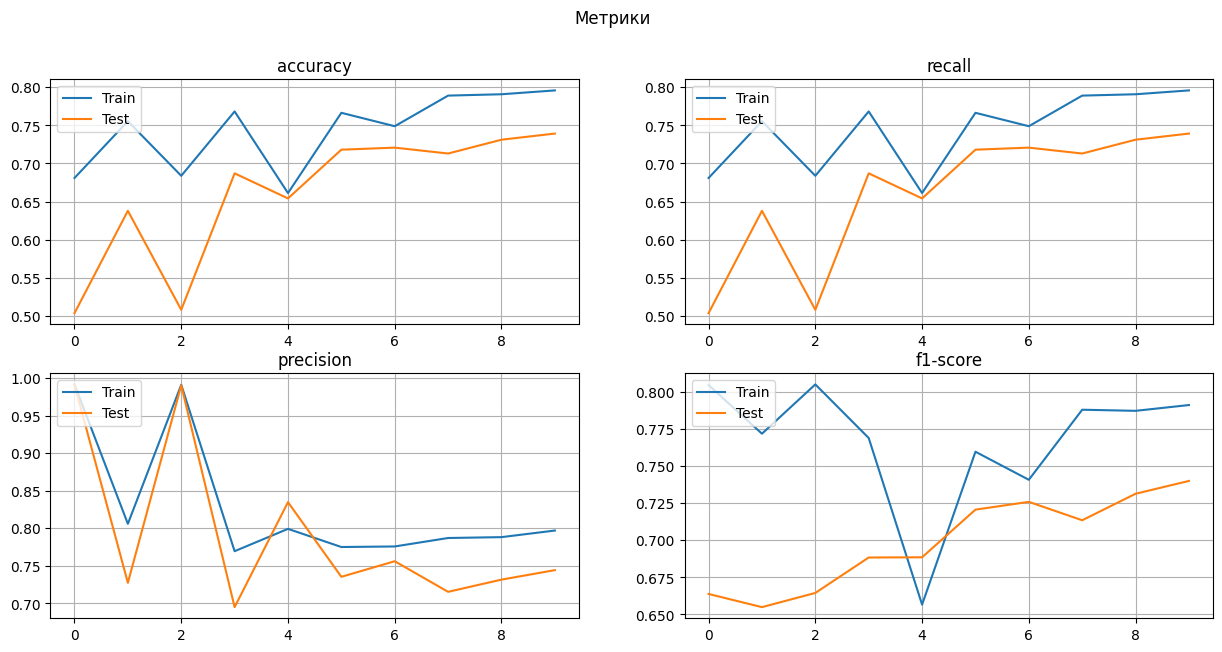

In [95]:
draw_metrics()

## №3 Self-attention

In [119]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [133]:
class LSTM(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, pad_idx, weigths):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = Embedding(input_size, embedding_dim,  _weight = weigths, padding_idx = pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=2, batch_first=True, dropout=0.25)
        self.fc = Linear(hidden_size, output_size)

        self.attention = SelfAttention(hidden_size)
        self.drop = nn.Dropout(0.2)
        self.sig = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        # print(embedded.shape)
        output, (hidden, cell) = self.lstm(embedded)
        # print(output.shape)
        # output = self.drop(output)

        output = self.attention(output)
        # print(output[:, -1, :].shape)
        output = self.drop(output)
        output = self.fc(output[:, -1, :])
        output = self.sig(output)
       
        return output

In [134]:
lstm = LSTM(input_size=num,
            embedding_dim=embedding_dim,
            hidden_size=128,
            output_size=2,
            pad_idx = word_dict['__pad__'],
            weigths = emb_weights
)

lstm = lstm.to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
weight = torch.Tensor(class_weights).to(device)
print('Weight', weight)
loss_fn = nn.BCELoss(weight=weight)

print(lstm)

Weight tensor([0.3216, 0.6784], device='cuda:0')
LSTM(
  (embedding): Embedding(63899, 64, padding_idx=50606)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
    (softmax): Softmax(dim=2)
  )
  (drop): Dropout(p=0.2, inplace=False)
  (sig): Sigmoid()
)


In [135]:
train_model(lstm, epochs = 10)

100%|█████████████████████████████████████████| 227/227 [00:22<00:00, 10.14it/s]


Epoch: 0
Train
F1-мера: 81.59%
Precision: 81.74%
Recall: 81.48%
Accuracy: 81.48%
Loss: 42.34
Матрица ошибок:
       0      1
0  10075   4526
1   3883  26914
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.72      0.69      0.71     14601
           1       0.86      0.87      0.86     30797

    accuracy                           0.81     45398
   macro avg       0.79      0.78      0.79     45398
weighted avg       0.81      0.81      0.81     45398

Test
F1-мера: 74.01%
Precision: 75.15%
Recall: 73.84%
Accuracy: 73.84%
Loss: 7.39
Матрица ошибок:
      0     1
0  1959  1020
1   539  2442
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.78      0.66      0.72      2979
           1       0.71      0.82      0.76      2981

    accuracy                           0.74      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:22<00:00, 10.08it/s]


Epoch: 1
Train
F1-мера: 85.71%
Precision: 88.69%
Recall: 84.74%
Accuracy: 84.74%
Loss: 36.46
Матрица ошибок:
      0      1
0  8712   5889
1  1037  29760
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72     14601
           1       0.83      0.97      0.90     30797

    accuracy                           0.85     45398
   macro avg       0.86      0.78      0.81     45398
weighted avg       0.85      0.85      0.84     45398

Test
F1-мера: 73.34%
Precision: 80.69%
Recall: 72.08%
Accuracy: 72.08%
Loss: 8.16
Матрица ошибок:
      0     1
0  1529  1450
1   214  2767
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.88      0.51      0.65      2979
           1       0.66      0.93      0.77      2981

    accuracy                           0.72      5960
   macro avg     

100%|█████████████████████████████████████████| 227/227 [00:22<00:00, 10.01it/s]


Epoch: 2
Train
F1-мера: 91.32%
Precision: 91.43%
Recall: 91.42%
Accuracy: 91.42%
Loss: 23.04
Матрица ошибок:
       0      1
0  13370   1231
1   2664  28133
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     14601
           1       0.96      0.91      0.94     30797

    accuracy                           0.91     45398
   macro avg       0.90      0.91      0.90     45398
weighted avg       0.92      0.91      0.92     45398

Test
F1-мера: 80.50%
Precision: 80.52%
Recall: 80.50%
Accuracy: 80.50%
Loss: 6.54
Матрица ошибок:
      0     1
0  2421   558
1   604  2377
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      2979
           1       0.81      0.80      0.80      2981

    accuracy                           0.81      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:22<00:00,  9.93it/s]


Epoch: 3
Train
F1-мера: 95.15%
Precision: 95.25%
Recall: 95.12%
Accuracy: 95.12%
Loss: 14.84
Матрица ошибок:
       0      1
0  13116   1485
1    732  30065
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     14601
           1       0.95      0.98      0.96     30797

    accuracy                           0.95     45398
   macro avg       0.95      0.94      0.94     45398
weighted avg       0.95      0.95      0.95     45398

Test
F1-мера: 78.80%
Precision: 80.11%
Recall: 78.64%
Accuracy: 78.64%
Loss: 7.40
Матрица ошибок:
      0     1
0  2087   892
1   381  2600
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      2979
           1       0.74      0.87      0.80      2981

    accuracy                           0.79      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:23<00:00,  9.71it/s]


Epoch: 4
Train
F1-мера: 96.32%
Precision: 96.31%
Recall: 96.32%
Accuracy: 96.32%
Loss: 11.22
Матрица ошибок:
       0      1
0  13847    754
1    916  29881
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     14601
           1       0.98      0.97      0.97     30797

    accuracy                           0.96     45398
   macro avg       0.96      0.96      0.96     45398
weighted avg       0.96      0.96      0.96     45398

Test
F1-мера: 78.39%
Precision: 78.71%
Recall: 78.36%
Accuracy: 78.36%
Loss: 8.38
Матрица ошибок:
      0     1
0  2209   770
1   520  2461
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      2979
           1       0.76      0.83      0.79      2981

    accuracy                           0.78      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:22<00:00,  9.88it/s]


Epoch: 5
Train
F1-мера: 96.88%
Precision: 96.88%
Recall: 96.88%
Accuracy: 96.88%
Loss: 9.15
Матрица ошибок:
       0      1
0  13944    657
1    759  30038
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     14601
           1       0.98      0.98      0.98     30797

    accuracy                           0.97     45398
   macro avg       0.96      0.97      0.96     45398
weighted avg       0.97      0.97      0.97     45398

Test
F1-мера: 77.60%
Precision: 78.14%
Recall: 77.53%
Accuracy: 77.53%
Loss: 10.48
Матрица ошибок:
      0     1
0  2145   834
1   505  2476
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      2979
           1       0.75      0.83      0.79      2981

    accuracy                           0.78      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:22<00:00,  9.93it/s]


Epoch: 6
Train
F1-мера: 97.18%
Precision: 97.18%
Recall: 97.18%
Accuracy: 97.18%
Loss: 8.30
Матрица ошибок:
       0      1
0  14099    502
1    777  30020
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     14601
           1       0.98      0.97      0.98     30797

    accuracy                           0.97     45398
   macro avg       0.97      0.97      0.97     45398
weighted avg       0.97      0.97      0.97     45398

Test
F1-мера: 78.39%
Precision: 78.51%
Recall: 78.37%
Accuracy: 78.37%
Loss: 10.91
Матрица ошибок:
      0     1
0  2256   723
1   566  2415
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2979
           1       0.77      0.81      0.79      2981

    accuracy                           0.78      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:22<00:00,  9.91it/s]


Epoch: 7
Train
F1-мера: 97.57%
Precision: 97.56%
Recall: 97.57%
Accuracy: 97.57%
Loss: 7.17
Матрица ошибок:
       0      1
0  14061    540
1    565  30232
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14601
           1       0.98      0.98      0.98     30797

    accuracy                           0.98     45398
   macro avg       0.97      0.97      0.97     45398
weighted avg       0.98      0.98      0.98     45398

Test
F1-мера: 77.88%
Precision: 78.37%
Recall: 77.82%
Accuracy: 77.82%
Loss: 12.94
Матрица ошибок:
      0     1
0  2161   818
1   504  2477
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      2979
           1       0.75      0.83      0.79      2981

    accuracy                           0.78      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:22<00:00,  9.94it/s]


Epoch: 8
Train
F1-мера: 97.94%
Precision: 97.99%
Recall: 97.93%
Accuracy: 97.93%
Loss: 6.22
Матрица ошибок:
       0      1
0  13829    772
1    170  30627
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     14601
           1       0.98      0.99      0.98     30797

    accuracy                           0.98     45398
   macro avg       0.98      0.97      0.98     45398
weighted avg       0.98      0.98      0.98     45398

Test
F1-мера: 75.56%
Precision: 78.07%
Recall: 75.20%
Accuracy: 75.20%
Loss: 15.27
Матрица ошибок:
      0     1
0  1883  1096
1   382  2599
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72      2979
           1       0.70      0.87      0.78      2981

    accuracy                           0.75      5960
   macro avg  

100%|█████████████████████████████████████████| 227/227 [00:22<00:00, 10.07it/s]


Epoch: 9
Train
F1-мера: 98.29%
Precision: 98.30%
Recall: 98.29%
Accuracy: 98.29%
Loss: 5.34
Матрица ошибок:
       0      1
0  14084    517
1    260  30537
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14601
           1       0.98      0.99      0.99     30797

    accuracy                           0.98     45398
   macro avg       0.98      0.98      0.98     45398
weighted avg       0.98      0.98      0.98     45398

Test
F1-мера: 76.81%
Precision: 77.52%
Recall: 76.71%
Accuracy: 76.71%
Loss: 14.05
Матрица ошибок:
      0     1
0  2096   883
1   505  2476
------------------------------------------------
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      2979
           1       0.74      0.83      0.78      2981

    accuracy                           0.77      5960
   macro avg  

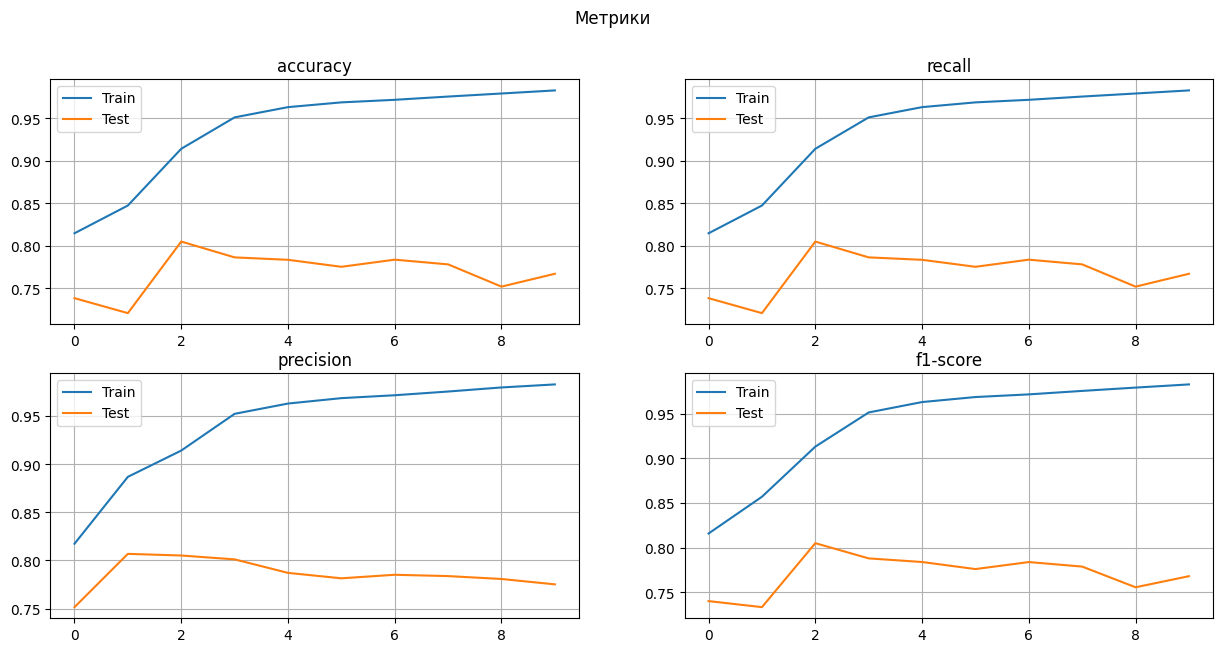

In [136]:
draw_metrics()